# Feature detection

Sossa lists the step in border detection as:

1. Noise aliasing
2. Border improvement
3. Border localization

Let us define a generic function to carry border detection. This function will take as arguments the image data (pixel matrix), a function to aliase the noise, a function to improve the border and a function to locate the border. These
having the identity function as defaults.

In [1]:
from scipy import misc
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
figsize(18, 9)

In [2]:
def detect_edges(
    image_data,
    aliase_noise=lambda x: x.copy(),
    improve_edges=lambda x: x.copy(),
    locate_edges=lambda x: x.copy()):
    after_noise_aliasing = aliase_noise(image_data)
    after_improving_edges = improve_edges(after_noise_aliasing)
    after_locating_edges = locate_edges(after_improving_edges)
    result = after_locating_edges
    return result

Let's get an image to work with.

In [18]:
IMAGE_PATH = 'house.jpg'
raw_image_data = misc.imread(IMAGE_PATH)
gray_image_data = misc.imread(IMAGE_PATH, mode='L')

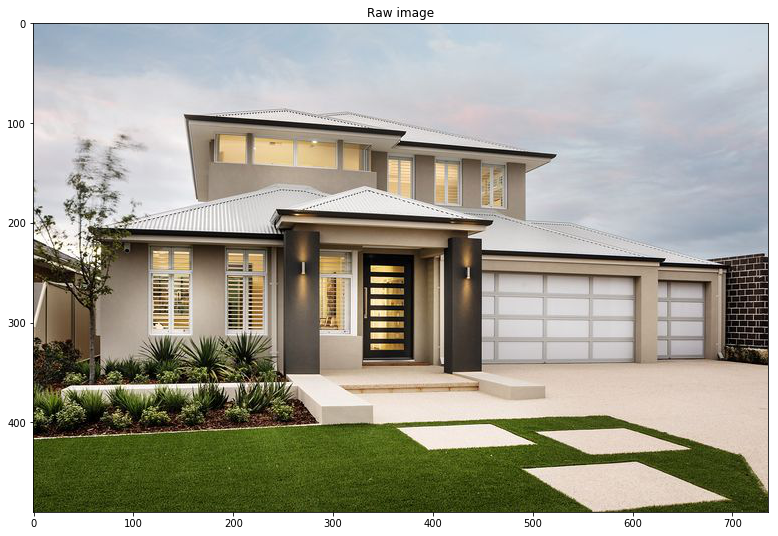

In [19]:
plt.figure()
plt.title('Raw image')
plt.imshow(raw_image_data)

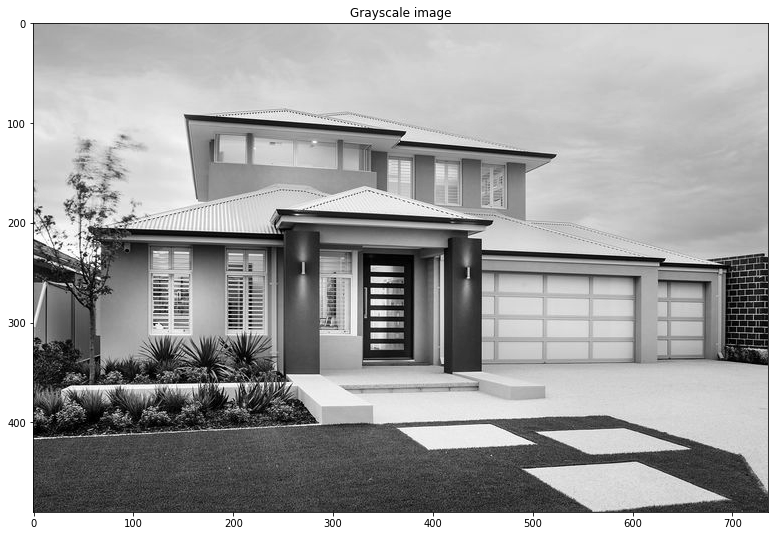

In [97]:
plt.figure()
plt.title('Grayscale image')
plt.imshow(gray_image_data, cmap='gray')

Right now our function does nothing, (since the default of the functions that perform the three steps are the identity).

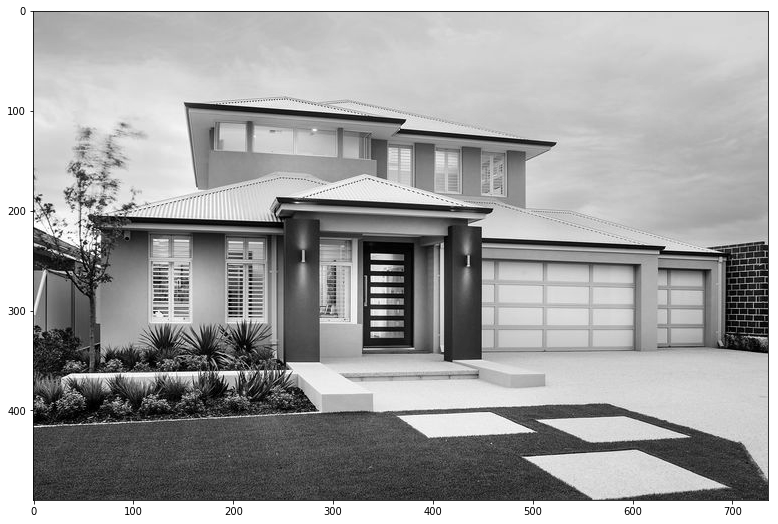

In [21]:
edges = detect_edges(gray_image_data)
plt.imshow(edges, cmap='gray')

## Edge detection based on the first derivative


The edge "improvers" exist to make emphasis on the regions of the image where significative changes of intensity occur. The vast majority of them use the first derivative and some use the second.

Let $$G[f(x,y)] = \left[ \begin{matrix}G_x\\G_y\end{matrix} \right]$$
$$ \vert\vert G[f(x,y)] \vert\vert = \sqrt{G_x^2 + G_y^2} $$

For computational complexity issues one can also use the similar formulations:

$$ \vert\vert G[f(x,y)] \vert\vert = G_x + G_y $$
$$ \vert\vert G[f(x,y)] \vert\vert = max(G_x, G_y) $$
$$ \theta(x, y) = arctan \frac{G_y}{G_x}$$

In [7]:
# We will use the np.diff to calculate the nth differences along an axis
np_diff_result = np.diff(gray_image_data, axis=1)
manual_diff_result = gray_image_data[...,1:] - gray_image_data[...,0:-1]
np.all(np.equal(manual_diff_result, np_diff_result))

True

In [57]:
temp = np.zeros(gray_image_data.shape)
temp = temp[...,:-1] + np.diff(gray_image_data, axis=1)

In [88]:
def first_differences_gradient(image_data, axis=0):
    return np.diff(image_data, axis=axis)

def gradient_by_addition(image_data, gradient_f):
    gradient_x = np.zeros(gray_image_data.shape)
    gradient_x[...,:-1] += np.diff(gray_image_data, axis=1)
    gradient_y = np.zeros(gray_image_data.shape)
    gradient_y[:-1,...] += np.diff(gray_image_data, axis=0)
    result = gradient_x + gradient_y
    return result

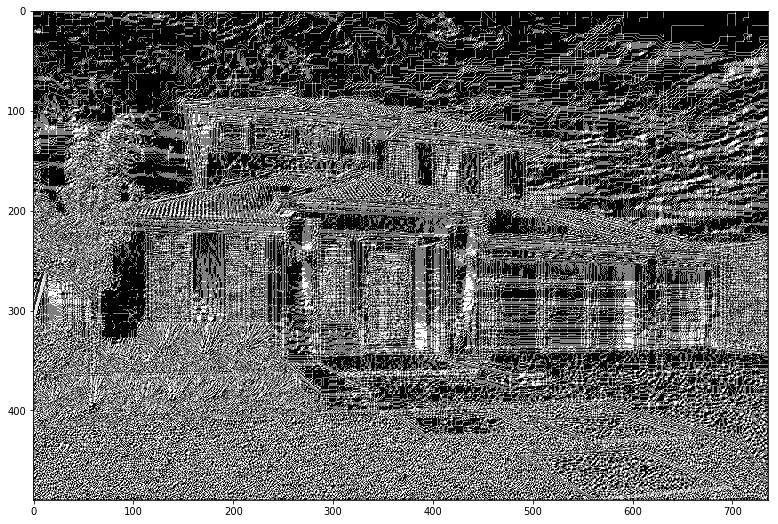

In [87]:
result = gradient_by_addition(gray_image_data, first_differences_gradient)
result = np.absolute(result)
plt.imshow(result, cmap='gray')

Which is the same as if we used numpys `np.gradient`

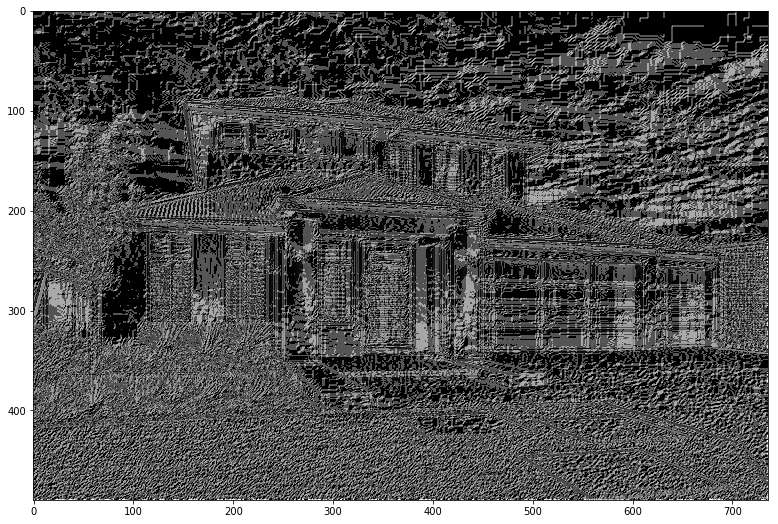

In [85]:
np_2_gradient_x, np_2_gradient_y = np.gradient(gray_image_data)
result = np_2_gradient_x + np_2_gradient_y
result = np.absolute(result)
plt.imshow(result, cmap='gray')

The difference between the `np.gradient` results and the ones we computed manually by first difference lie on the fact that `np.gradient` does some more fancy stuff.

## Convolution

Convolution is the most important and fundamental concept in signal processing and analysis. 

Convolution operatones on two signals in 1D or 2 images in 2D. You can think of one as the input and the other as a filter (called the kernel). 

For this to work, we assume that all entries outside the boundaries of the image are zeroes.

The book says that this edge enhancer based on the first derivative (first differences) is equivalent to the application of the convolution given by:

$$[ \begin{matrix}-1 & 1\end{matrix}] + \left[ \begin{matrix}-1\\1\end{matrix} \right]$$

Which I think would be the same as using the kernel

$$ \left[ \begin{matrix} -2 & 1 \\ 1 & 0 \end{matrix} \right] $$

Numpy only has convolution in 1D, but scipy provides a function to convolve in 2D.

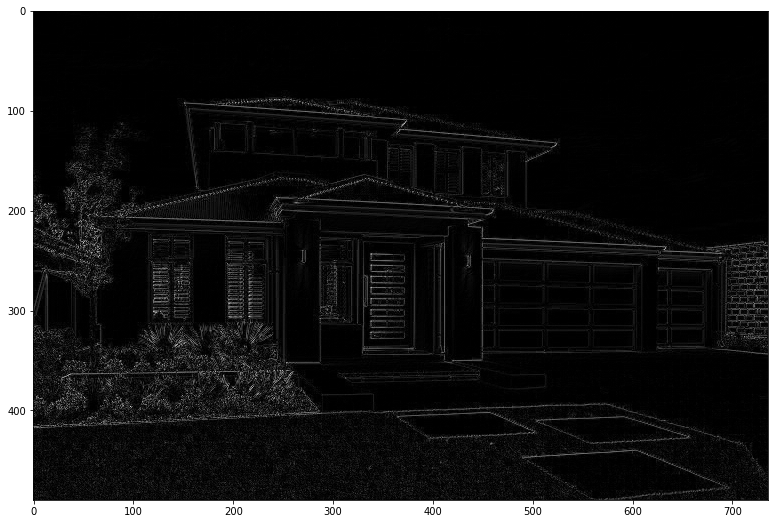

In [81]:
from scipy import signal
first_differences_kernel = np.array([[-2, 1], [1, 0]])
result = signal.convolve2d(gray_image_data, first_differences_kernel, mode='same') # mode in ['full', 'valid', 'same']
result = np.absolute(result)
plt.imshow(result, cmap='gray')

## Roberts cross gradient

$$G[f(x,y)] = f(x,y) - f(x+1,y+1) + f(x+1,y) - f(x,y+1)$$

Which is given by the mask

$$ \left[ \begin{matrix}1 & 1 \\ -1 & -1\end{matrix} \right] $$

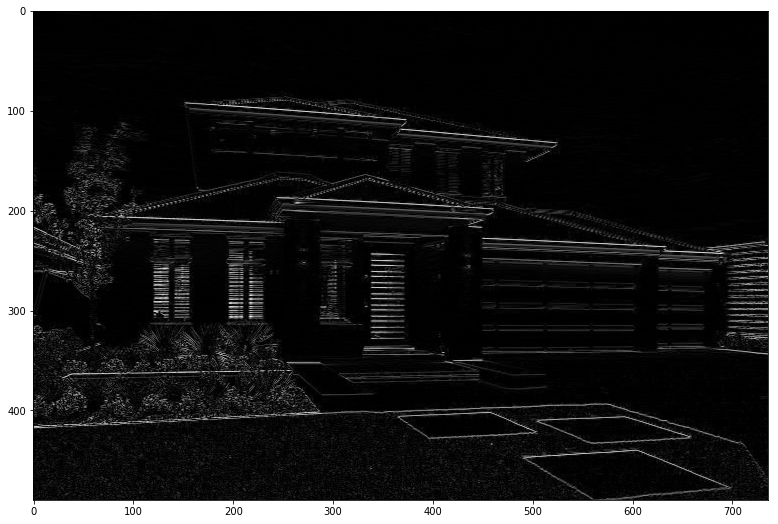

In [90]:
roberts_kernel = np.array([[1, 1], [-1, -1]])
result = signal.convolve2d(gray_image_data, roberts_kernel, mode='same') # mode in ['full', 'valid', 'same']
result = np.absolute(result)
plt.imshow(result, cmap='gray')

Up untill now, the values of our gradients have been calculated on the interpolated positions: Hasta ahora, los valores de nuestros gradientes han quedado en las posiciones interpoladas $(x+1/2, y+1/2)$. This can be corrected with methods like the following:

## Sobel's enhancer

We'll imagine our pixels with a neighbourhood like this:

$$ \begin{matrix} a_0 & a_1 & a_2 \\ a_7 & (x, y) & a_3 \\ a_6 & a_5 & a_4 \end{matrix} $$

Then we'll have the magnitud of the gradient given by

$$ M = \sqrt{s_x^2 + s_y^2} $$

Where $s_x = (a_6 + ca_4 + a_5) - (a_0 + ca_1 + a_2)$ and $s_y = (a_2 + ca_3 + a_4) - (a_0 + ca_6 + a_7)$

The constant takes a value of 2.

Where we can use the masks

$$ s_x = \left[ \begin{matrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{matrix} \right] $$
$$ s_y = \left[ \begin{matrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{matrix} \right] $$

And therefore a kernel of

$$ \left[ \begin{matrix} -2 & -2 & 0 \\ -2 & 0 & 2 \\ 0 & 2 & 2 \end{matrix} \right] $$

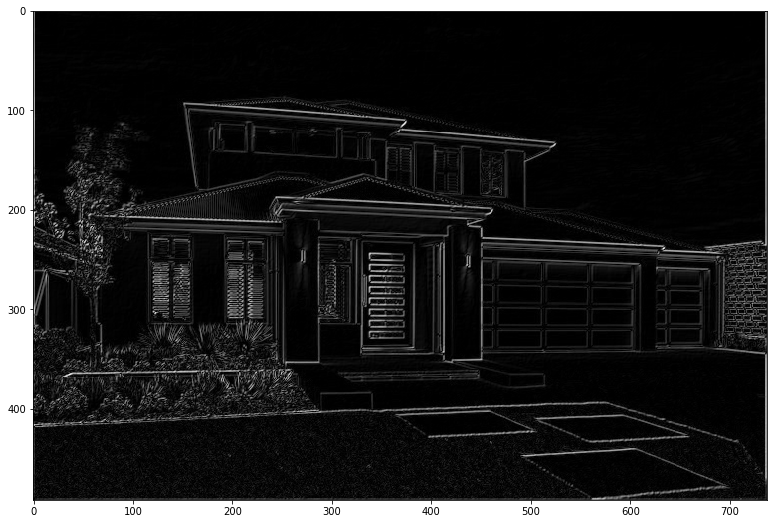

In [94]:
sobels_kernel = np.array([[-2, -2, 0], [-2, 0, 2], [0, 2, 2]])
result = signal.convolve2d(gray_image_data, sobels_kernel)
result = np.absolute(result)
plt.imshow(result, cmap='gray')

## Methods based on the second derivative
### Laplace

Let us imagine our image as

$$ \left[ \begin{matrix} a_1 & a_2 & a_3 & a_4 \\ a_5 & a_6 & a_7 & a_8 \\ a_9 & a_{10} & a_{11} & a_{12} \end{matrix} \right] $$

Let's focus on $a_6$. The second derivative is the change of changes. If we think about being "centered" around $a_6$ we can think of the change $a_6 - a_5$ and the change $a_7 - a_6$. This is, of course, the change of y with respect to x. The second derivative would be the change or difference of these two changes so $a_7 - a_4 - (a_6 - a_5) = a_7 - 2a_6 + a_5$. If we let $a_6 = f(x, y)$ then we have:

$$ f''(x,y) = (f(x, y + 1) - f(x, y)) - (f(x,y) - f(x, y-1)) = f(x, y - 1) - 2f(x, y) + f(x, y + 1)$$

The case of the change of $x$ with respect to $y$ is similar and so we end up with the masks:

$$ \left[ \begin{matrix}1 & -2 & 1 \end{matrix} \right] $$ and $$\left[ \begin{matrix}1 \\ -2 \\ 1 \end{matrix} \right] $$

if we combine them we end up with:

$$ \left[ \begin{matrix}0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{matrix} \right] $$

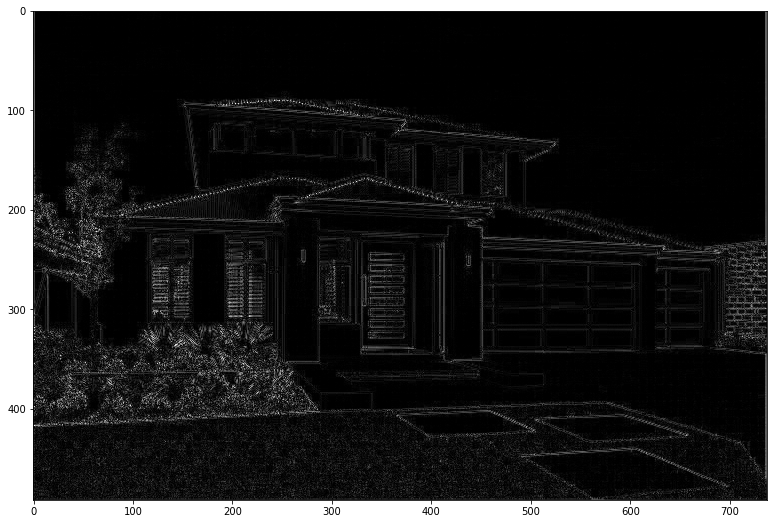

In [96]:
laplace_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
result = signal.convolve2d(gray_image_data, laplace_kernel)
result = np.absolute(result)
plt.imshow(result, cmap='gray')

### Second directional derivative

I didn't get it.

### Closing remarks on the second derivative methods

The second derivative methods are rarely used because they tend to introduce a lot of noise. Even small changes may cause the second derivative to cross the zero threshold.